In [1]:
import torch
import os
from matplotlib import pyplot as plt
import seaborn as sns
from models.cnp import CNP
from models.wta_cnp import WTA_CNP

In [2]:
# colors = [sns.color_palette('tab10')[0], sns.color_palette('tab10')[1], sns.color_palette('tab10')[2], sns.color_palette('tab10')[3]]
# sns.set_palette('tab10')
colors = ['tomato', 'aqua', 'limegreen', 'gold', 'mediumslateblue', 'lightcoral', 'darkorange', 'teal']

root_path = "/home/yigit/projects/mbcnp/outputs/combined/"
test_name = "last"
test_path = f'{root_path}{test_name}/'
out_path = f'{test_path}comparison_num/'

mse_loss = torch.nn.MSELoss()

if not os.path.exists(out_path):
    os.makedirs(out_path)

cnp_errs, wta_errs = [], []

In [3]:
# common_point: intersecting trajectories
common_points = {0:[[0,2],[1,3]], 1:[[0,2],[1,3]], 2:[[0,2],[1,3]], 3:[[0,2],[1,3]], 4:[[0,2],[1,3]], 
                27:[[0,1]], 28:[[0,1]], 29:[[0,1]], 30:[[0,1]], 31:[[0,1]], 32:[[0,1]], 33:[[0,1]], 34:[[0,1]], 35:[[0,1]], 36:[[0,1]], 37:[[0,1]], 38:[[0,1]], 39:[[0,1]], 40:[[0,1]],
                58:[[0,3],[1,2]], 59:[[0,3],[1,2]], 60:[[0,3],[1,2]], 61:[[0,3],[1,2]], 62:[[0,3],[1,2]], 63:[[0,3],[1,2]], 64:[[0,3],[1,2]], 65:[[0,3],[1,2]], 66:[[0,3],[1,2]], 67:[[0,3],[1,2]], 68:[[0,3],[1,2]],
                95:[[2,3]], 96:[[2,3]], 97:[[2,3]], 98:[[2,3]], 99:[[2,3]], 100:[[2,3]], 101:[[2,3]], 102:[[2,3]], 103:[[2,3]], 104:[[2,3]],
                130:[[0,2],[1,3]], 131:[[0,2],[1,3]], 132:[[0,2],[1,3]], 133:[[0,2],[1,3]], 134:[[0,2],[1,3]], 135:[[0,2],[1,3]], 136:[[0,2],[1,3]], 137:[[0,2],[1,3]], 138:[[0,2],[1,3]], 139:[[0,2],[1,3]], 140:[[0,2],[1,3]], 141:[[0,2],[1,3]],
                160:[[0,1]], 161:[[0,1]], 162:[[0,1]], 163:[[0,1]], 164:[[0,1]], 165:[[0,1]], 166:[[0,1]], 167:[[0,1]], 168:[[0,1]], 169:[[0,1]], 170:[[0,1]], 171:[[0,1]],
                195:[[1,2],[0,3]], 196:[[1,2],[0,3]], 197:[[1,2],[0,3]], 198:[[1,2],[0,3]], 199:[[1,2],[0,3]]}
                     
    
# test_idx = torch.tensor([0, 1, 2, 27,28,29,30,31, 32, 33, 34, 35,36,37,38, 64, 65, 66, 67, 68, 97, 98, 99, 100, 101, 130, 131, 132, 133, 134, 163, 164, 165, 166, 167, 197, 198, 199])
# test_idx = torch.tensor([1, 2, 27,28,29,30,31, 34, 35,36,37,38, 64, 67, 68, 97, 100, 101, 130, 133, 134, 163, 166, 167, 197, 198])
# test_idx = torch.arange(200)
test_idx = list(common_points.keys())


def evaluate(cnp, wta, x, y):
    num_samples, dy = y.shape[0], y.shape[2]
    cnp_err, wta_err = 0, 0

    for test_id in test_idx:
        obs = torch.zeros(num_samples, 1, 2)
        for i in range(num_samples):
            obs[i, 0, 0] = x[i, test_id, 0]
            obs[i, 0, 1] = y[i, test_id, 0]
        tar = torch.linspace(0, 1, 200).unsqueeze(0).unsqueeze(-1).repeat(num_samples, 1, 1)

        cnp.eval()
        wta.eval()

        with torch.no_grad():
            p_cnp, _ = cnp(obs, tar)
            p_wta, g_wta = wta(obs, tar)

            dec_id = torch.argmax(g_wta.squeeze(1), dim=-1)
            for i in range(num_samples):  # for each observation in batch
                vp_means = p_wta[dec_id[i], i, :, :dy]
                if test_id in common_points.keys():
                    for commons in common_points[test_id]:
                        if i in commons:
                            wta_err += torch.min(torch.tensor([mse_loss(vp_means, y[commons[0]]), mse_loss(vp_means, y[commons[1]])])).item()
                            cnp_err += torch.min(torch.tensor([mse_loss(p_cnp[i, :, :cnp.output_dim], y[commons[0]]), 
                                                            mse_loss(p_cnp[i, :, :cnp.output_dim], y[commons[1]])])).item()
                        else:
                            wta_err += mse_loss(vp_means, y[i]).item()
                            cnp_err += mse_loss(p_cnp[i, :, :cnp.output_dim], y[i]).item()
                        break

                else:
                    wta_err += mse_loss(vp_means, y[i]).item()
                    cnp_err += mse_loss(p_cnp[i, :, :cnp.output_dim], y[i]).item()


    return cnp_err/len(test_idx), wta_err/len(test_idx)

# def draw():
#     test_ind = 165

#     plt_y_lim_up = torch.max(y) + 0.1
#     plt_y_lim_low = torch.min(y) - 0.1

#     plt.figure(figsize=(8, 6))
#     plt.ylim((plt_y_lim_low, plt_y_lim_up))
#     for i in range(num_samples):
#         plt.plot(x[i, :, 0].cpu(), y[i, :, 0].cpu(), colors[i%num_samples], label="Trajectory {}".format(i+1))
#         plt.scatter(x[i, test_ind, 0], y[i, test_ind, 0], c='k')

#     test_x = x[0, test_ind, 0].item()

#     plt.plot([test_x]*200, torch.linspace(-1, 1, 200), 'k--', alpha=0.5)

#     plt.legend()
#     plt.grid(True)
#     plt.xlabel('Time (t)')
#     plt.ylabel('Sensorimotor Value (SM(t))')
#     plt.title(f'Distinct Functions')

In [4]:
cnp_errs, wta_errs = [], []
num_tests = 0

for suffix in sorted(os.listdir(test_path)):
    if suffix.startswith('169'):
        d = os.path.join(test_path, suffix)
        if os.path.isdir(d):
            y = torch.load(f'{d}/y.pt')
            num_samples = y.shape[0]

            x = torch.linspace(0, 1, 200).repeat(num_samples, 1).view(num_samples, -1, 1)

            model_folder = d+'/saved_models/'
            cnp_model_path, wta_model_path = f'{model_folder}cnp_on_synth.pt', f'{model_folder}wta_on_synth.pt'

            cnp = CNP(1, 406, 1, 10, 10, 3, num_samples)
            wta = WTA_CNP(1, 1, 10, 10, [256, 256, 256], num_decoders=4, decoder_hidden_dims=[256, 256, 256], batch_size=num_samples)

            cnp.load_state_dict(torch.load(cnp_model_path, map_location=torch.device('cpu')))
            wta.load_state_dict(torch.load(wta_model_path, map_location=torch.device('cpu')))

            c, w = evaluate(cnp, wta, x, y)
            print(f'{suffix} - cnp: {c}, wta: {w}')
            cnp_errs.append(c)
            wta_errs.append(w)

            num_tests += 1

w_sum, c_sum = sum(wta_errs), sum(cnp_errs)
print(c_sum, w_sum, w_sum/c_sum)

1696338627 - cnp: 0.11352201227793188, wta: 0.058873947728239145
1696338835 - cnp: 0.08457365579344722, wta: 0.07186071773237242
1696344451 - cnp: 0.060234466814042695, wta: 0.07015419851415862
1696344462 - cnp: 0.1107400857827615, wta: 0.041256008747756125
1696358889 - cnp: 0.08086015407862114, wta: 0.050540245819541044
1696363331 - cnp: 0.12964289211698787, wta: 0.07722892703372634
1696364302 - cnp: 0.0695029267802425, wta: 0.08488074394929167
1696378976 - cnp: 0.08475523637457298, wta: 0.12418067312806881
1696388212 - cnp: 0.13477876012697762, wta: 0.06131160474270816
1696389172 - cnp: 0.08861273567432047, wta: 0.053411506546828365
1696390886 - cnp: 0.07342692323425291, wta: 0.05200022673718682
1696390916 - cnp: 0.10370317896343664, wta: 0.05675568448152486
1696419169 - cnp: 0.10057514249563057, wta: 0.04080028969349808
1696421615 - cnp: 0.10637521332514091, wta: 0.057840083088936095
1696423316 - cnp: 0.0717786597960567, wta: 0.052428619615615506
1696448702 - cnp: 0.0683624241777566

In [5]:
# obs = torch.Tensor([1.0, 0.0]).unsqueeze(0).unsqueeze(0)
run = '1696344462'
cnp.load_state_dict(torch.load(f'/home/yigit/projects/mbcnp/outputs/combined/last/{run}/saved_models/cnp_on_synth.pt', map_location=torch.device('cpu')))
wta.load_state_dict(torch.load(f'/home/yigit/projects/mbcnp/outputs/combined/last/{run}/saved_models/wta_on_synth.pt', map_location=torch.device('cpu')))

test_ind = 2
# test_ind = list(common_points.keys())[33]

obs = torch.zeros(num_samples, 1, 2)
for i in range(num_samples):
    obs[i, 0, 0] = x[i, test_ind, 0]
    obs[i, 0, 1] = y[i, test_ind, 0]
tar = torch.linspace(0, 1, 200).unsqueeze(0).unsqueeze(-1).repeat(num_samples, 1, 1)

with torch.no_grad():
    pred_cnp, _ = cnp(obs, tar)
    pred_wta, gate = wta(obs, tar)

# print(obs)
# print(pred_wta.shape, pred_cnp.shape, gate.shape)
# print(gate)

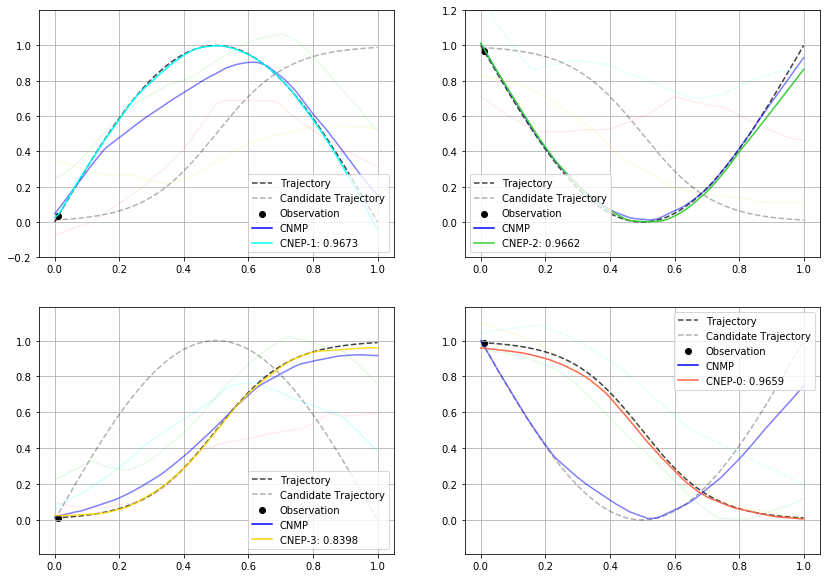

In [6]:
#region Plot
from matplotlib.lines import Line2D

batch_size = 4
rows, cols = torch.ceil(torch.sqrt(torch.tensor(batch_size))).int(), torch.floor(torch.sqrt(torch.tensor(batch_size))).int()
rows, cols = rows.item(), cols.item()
fig, axs = plt.subplots(rows, cols, figsize=(14, 10))
for i in range(rows):
    for j in range(cols):
        ind = i*cols+j
        plt_y_upper_lim, plt_y_lower_lim = torch.max(y[ind]) + 0.2, torch.min(y[ind]) - 0.2

        axs[i, j].scatter(x[ind, test_ind, 0], y[ind, test_ind, 0], label='Observation', c='k')
        axs[i, j].set_ylim((plt_y_lower_lim, plt_y_upper_lim))
        axs[i, j].plot(torch.linspace(0, 1, 200), y[ind], 'k--', alpha=0.75, label='Trajectory')  # data

        for commons in common_points[test_ind]:
            for c, common in enumerate(commons):
                if ind == common:
                    axs[i, j].plot(torch.linspace(0, 1, 200), y[commons[1-c]], 'k--', alpha=0.3, label='Candidate Trajectory')
        axs[i, j].plot(torch.linspace(0, 1, 200), pred_cnp[ind,:,0], 'b', alpha=0.5)  # cnp predictions

        handles = axs[i, j].get_legend_handles_labels()[0]
        handles.extend([Line2D([0], [0], label='CNMP', color='b')])

        best = torch.argmax(gate[ind, 0, :]).item()
        for k in range(batch_size):
            axs[i, j].plot(torch.linspace(0, 1, 200), pred_wta[k,ind,:,0], color=colors[k%batch_size], alpha=max(0.1, gate[ind, 0, k].item()))  # wta predictions
            if k==best:
                handles.extend([Line2D([0], [0], label=f'CNEP-{k}: {gate[ind, 0, k].item():.4f}', color=colors[k])])

        axs[i, j].legend(handles=handles, loc='best')
        axs[i, j].grid(True)
        
# plt.close()
#endregion

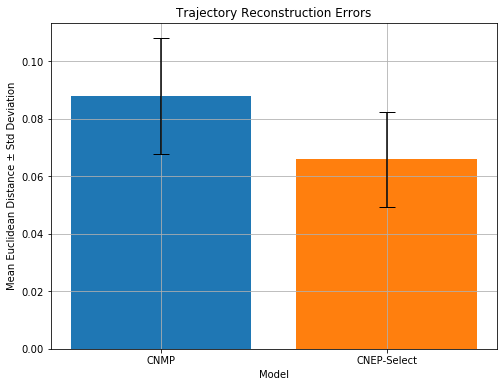

In [7]:
import numpy as np

plt.close()

colors = [sns.color_palette('tab10')[0], sns.color_palette('tab10')[1], sns.color_palette('tab10')[2], sns.color_palette('tab10')[3]]
sns.set_palette('tab10')

models = ['CNMP', 'CNEP-Select']
wta_errors, cnp_errors = np.array(wta_errs), np.array(cnp_errs)
mean = [np.mean(cnp_errors), np.mean(wta_errors)]
std_dev = [np.std(cnp_errors), np.std(wta_errors)]
std_err = [np.std(cnp_errors)/np.sqrt(num_tests), np.std(wta_errors)/np.sqrt(num_tests)]

plt.figure(figsize=(8, 6))
plt.bar(models, mean, yerr=std_dev, capsize=8, color=colors)
 
plt.grid(True)
plt.xlabel('Model')
plt.ylabel('Mean Euclidean Distance ± Std Deviation')
plt.title('Trajectory Reconstruction Errors')

plt.show()

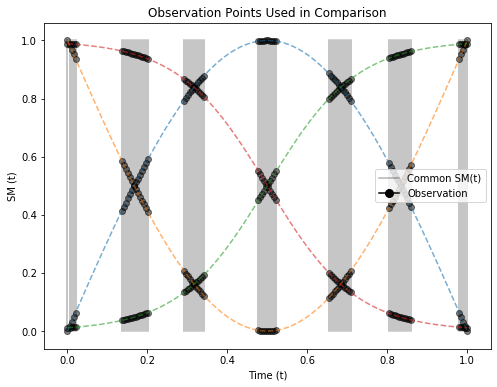

In [8]:
from matplotlib.lines import Line2D

plt.close()

plt.figure(figsize=(8, 6))
for i in range(num_samples):
    plt.plot(x[i, :, 0].cpu(), y[i, :, 0].cpu(), linestyle='dashed', alpha=0.6)

    for k in common_points.keys():
        plt.scatter(x[i, k, 0], y[i, k, 0], c='k', alpha=0.5)

        test_x = x[0, k, 0].item()
        plt.plot([test_x]*200, torch.linspace(0, 1, 200), 'k-', alpha=0.08)

plt.grid(False)
plt.xlabel('Time (t)')
plt.ylabel('SM (t)')
plt.title(f'Observation Points Used in Comparison')

handles = [Line2D([0], [0], label='Common SM(t)', color='k', alpha=0.3), 
           Line2D([0], [0], marker='o', color='k', label='Observation', markerfacecolor='k', markersize=8)]
plt.legend(handles=handles, loc='center right')

plt.show()

In [9]:
from scipy import stats

# Perform t-test
t_stat, p_value = stats.ttest_ind(cnp_errors, wta_errors)

# Output results
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

# Determine significance
alpha = 0.05
if p_value < alpha:
    print("The difference is statistically significant")
else:
    print("The difference is not statistically significant")

T-statistic: 4.310842440524243
P-value: 7.265226999371529e-05
The difference is statistically significant
